<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение и проверка данных</a></span></li><li><span><a href="#Изучение-воронки-событий" data-toc-modified-id="Изучение-воронки-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение воронки событий</a></span></li><li><span><a href="#Изучение-результатов-эксперимента" data-toc-modified-id="Изучение-результатов-эксперимента-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучение результатов эксперимента</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

## Предобработка данных

In [1]:
# импортируем библиотеки
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math as mth
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

In [2]:
import plotly.io as pio 
pio.renderers.default = "png" 
svg_renderer = pio.renderers["png"] 
svg_renderer.scale = 1.2


In [3]:
# импортируем данные
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep = '\t') 
except:
    data = pd.read_csv('/Users/konstantinzuev/БА/Jupiter/SP_2', sep = '\t')

In [4]:
pd.set_option('display.max_colwidth', None)
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Изменим название стодбцов для более удобной работы с ними.

In [5]:
# изменим названия столбцов для удобства работы с ними
data.columns = data.columns.str.lower()
data = data.rename(columns={'eventname': 'event_name', 
                            'deviceidhash':'user_deviceid_hash',
                            'eventtimestamp':'event_time'})

In [6]:
data

,event_name,user_deviceid_hash,event_time,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


После изменения названий столбцов проверим датасет на наличией пропусков в данных.

In [7]:
data.isnull().sum()

event_name            0
user_deviceid_hash    0
event_time            0
expid                 0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   event_name          244126 non-null  object
 1   user_deviceid_hash  244126 non-null  int64 
 2   event_time          244126 non-null  int64 
 3   expid               244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков нет. Теперь проверим датафрейм на наличие полных дубликатов.

In [9]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 413


Видим, что такие дубликаты есть. Удалим их.

In [10]:
data = data.drop_duplicates()


Также, столбец `event_time` имеет неверный тип данных, а также неудобный для работы с ним вид. Поработаем с ним.

In [11]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data

,event_name,user_deviceid_hash,event_time,expid
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   event_name          243713 non-null  object        
 1   user_deviceid_hash  243713 non-null  int64         
 2   event_time          243713 non-null  datetime64[ns]
 3   expid               243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


Столбец `event_time` преобразовали. Добавим отдельно в датасет столбец только с датами без указания времени.

In [13]:
data['date'] = pd.to_datetime(data['event_time']).dt.date

Согласно условиям задачи для анализа представлены 3 группы: 2 контрольные (группы А) и одна экспериментальная (группа В). Представляется, можно заранее сделать отдельный стольбец с указанием группы для будущей работы с ними при необходимости.

In [14]:
# определяем функцию для категоризации групп
def categorize_groups(group):
    if group in [246,247]:
        return 'A'
    elif group == 248:
        return 'B'

In [15]:
# вставляем новый столбец
data.insert(4, 'group_ab', data['expid'].apply(categorize_groups), False)
data.head()

,event_name,user_deviceid_hash,event_time,expid,group_ab,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,A,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,A,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,B,2019-07-25


Полагаю, на этом предобработку можно закончить.

## Изучение и проверка данных

Посмотрим,сколько всего событий, пользователей в логе, и сколько в среднем событий приходится на одного пользователя.


In [16]:
# cчитаем, сколько всего событий в логе
old_events_num = data['event_name'].count()
print('Всего событий в логе -',old_events_num)

Всего событий в логе - 243713


In [17]:
# считаем, сколько всего уникальных событий есть
old_unique_events = data['event_name'].nunique()
print('Уникальных событий - ', old_unique_events)

Уникальных событий -  5


In [18]:
#считаем, сколько раз встречается то или иное уникальное событие
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Для большей наглядности построим гистограмму

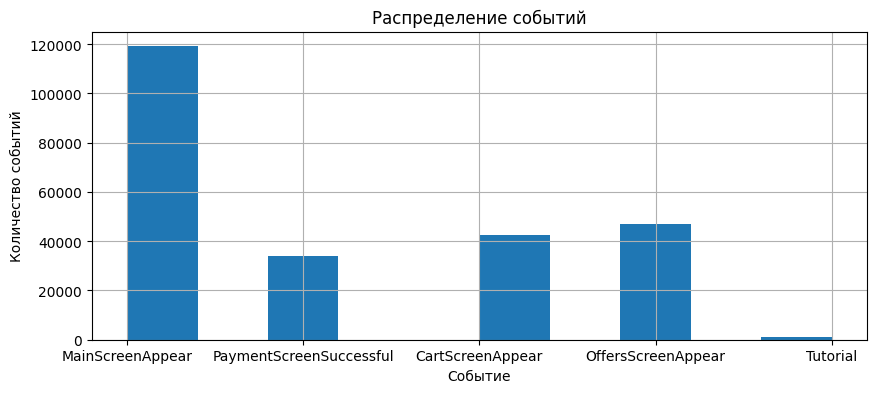

In [19]:
data['event_name'].hist(figsize=(10,4))
plt.xlabel('Событие')
plt.ylabel('Количество событий')
plt.title('Распределение событий')
plt.show()

Итак, в датасете 243713 события, 5 уникальных видов. Наиболее частое событие - `MainScreenAppear`, почти половина от всех, наиболее редкое событие - `Tutorial`.

In [20]:
# считаем, сколько уникальных пользователей в логе
old_users_num = data['user_deviceid_hash'].nunique()
print('В логе',old_users_num, 'уникальных пользователей.')

В логе 7551 уникальных пользователей.


In [21]:
# считае, сколько в среднем событий приходится на одного пользователя
data.groupby('user_deviceid_hash').agg({'event_name':'count'}).mean()

event_name    32.275593
dtype: float64

Видим, что в датасете 7551 уникальный пользователь, и в среднем на одного пользователя приходится 32 события.     
Однако, в ситуации, когда в данных могут быть выбросы, считать среднее может оказаться некорректным, так как среднее значение слишком чувствительно к ним. В таком случае, следует считать медиану.     
Посмотрим, есть ли в наших данных выбросы. Для этого воспользуемся методом `describe` и построим "ящик с усами".

In [22]:
data.groupby('user_deviceid_hash')\
    .agg({'event_name':'count'})\
    .sort_values(by='event_name', ascending=False)\
    .describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


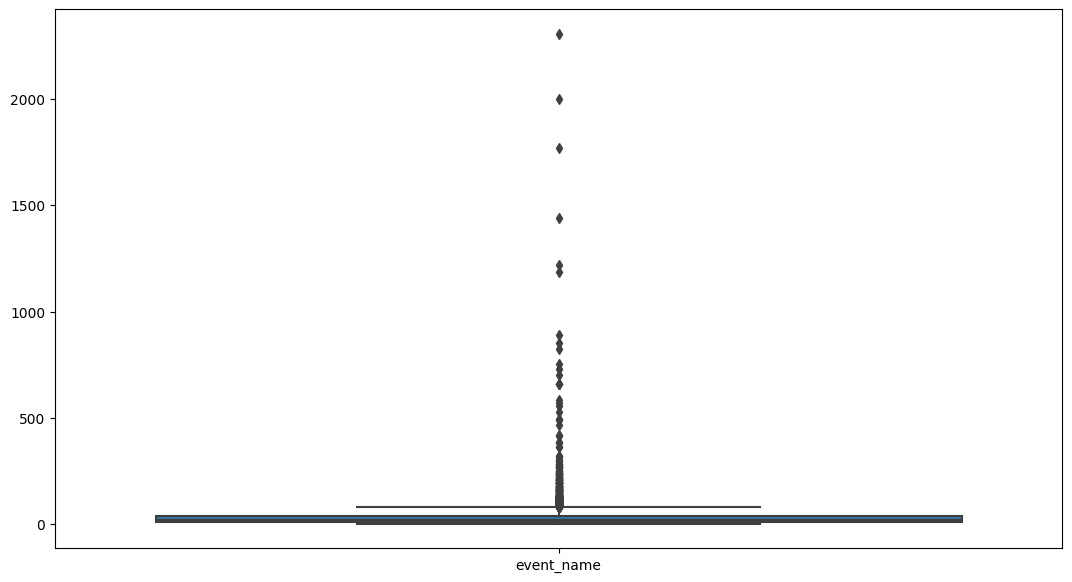

In [23]:
plt.figure(figsize=(13,7))
sns.boxplot(data=data.groupby('user_deviceid_hash').agg({'event_name':'count'}))
plt.show()

Однозначно видим, что в наших данных есть выбросы. В среднем один пользователь совершает 32 события. Однако, например, есть пользователь, который совершил аж 2307 событий. Даже один такой пользователь может существенно исказить среднее значение.     
В таком случае мы можем удалить выбросы и далее также использовать среднее значение или посчитать медиану, которая более устойчива к выбросам.    
Посчитаем медиану.

In [24]:
data.groupby('user_deviceid_hash').agg({'event_name':'count'}).median()

event_name    20.0
dtype: float64

Медианное количество событий на одного пользователя составляет 20 событий - существенно меньше среднего значения!

Хоть и медианное значение уже было посчитано при использовании метода `describe`, для наглядности мы посчитали его снова.

Определим, за какой период времени у нас имеются данные - для этого найдем минимальную и максимальную даты, а также гистограмму по дате и времени

In [25]:
#находим минимальную дату и время
data['event_time'].min()

Timestamp('2019-07-25 04:43:36')

In [26]:
#находим максимальную дату и время
data['event_time'].max()

Timestamp('2019-08-07 21:15:17')

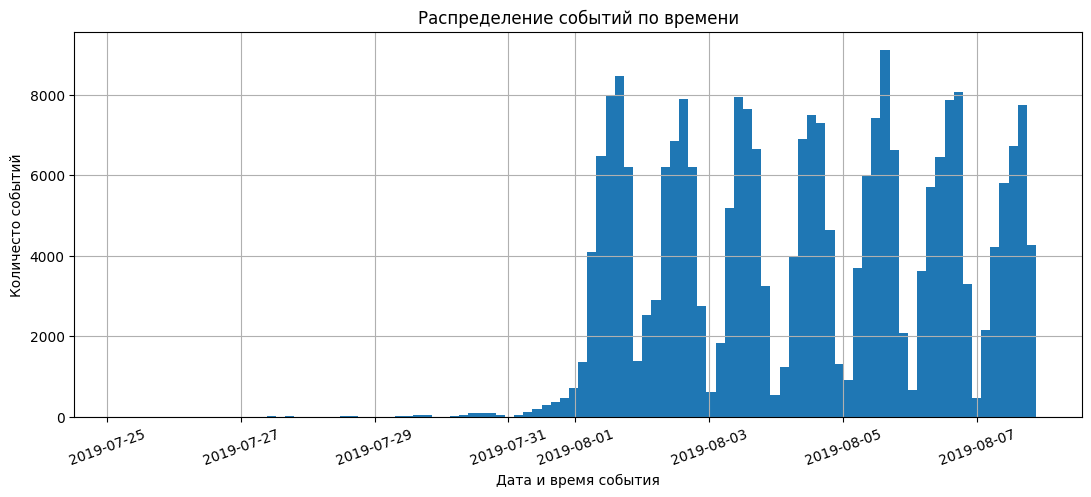

In [27]:
# строим гистограмму
data['event_time'].hist(figsize=(13,5), bins=100)
plt.xlabel('Дата и время события')
plt.ylabel('Количесто событий')
plt.xticks(rotation=20)
plt.title('Распределение событий по времени')
plt.show()

На гистограмме можно заметить определенную цикличность появления событий. При этом, четкость циклов начинает отображаться, начиная примерно с 01.08.2019. Полагаю, что до данной даты у нас собраны неполные данные, которые можно отбросить.

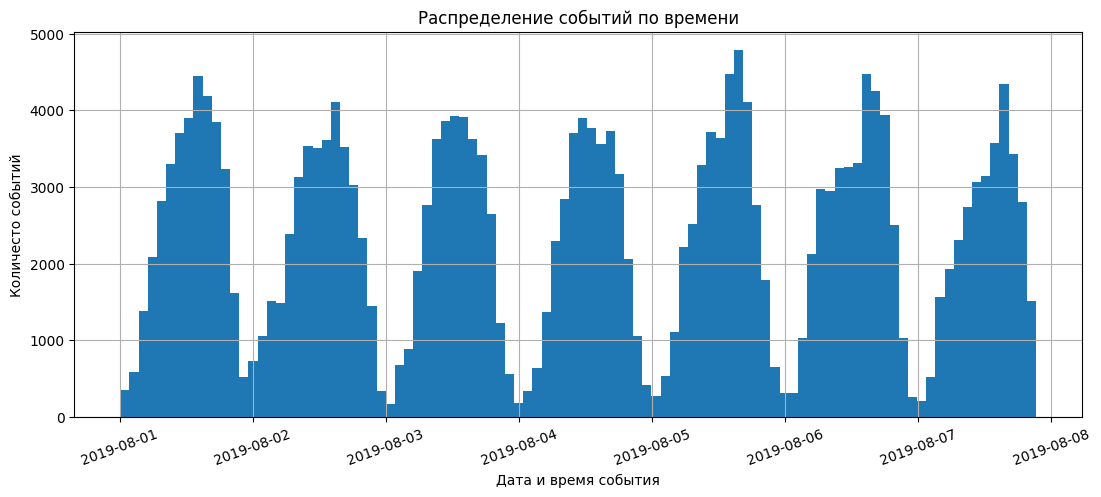

In [28]:
# удаляем ненужные данные из датасета и повторно строим гистограмму для проверки
data = data.loc[data['event_time'] > '2019-08-01']
data['event_time'].hist(figsize=(13,5), bins=100)
plt.xlabel('Дата и время события')
plt.ylabel('Количесто событий')
plt.xticks(rotation=20)
plt.title('Распределение событий по времени')
plt.show()

Видим, что на графике больше нет "хвостов", и все циклы ровно отрисованы.    

Теперь посмотрим, сколько событий и пользователей мы потеряли в результате удаления старых данных, а также убедимся, что у нас остались пользователи из всех 3х групп теста.

In [29]:
# cчитаем, сколько всего событий в логе осталось
print('Событий в логе осталось', data['event_name'].count(), ', было - ', old_events_num,
      '\n','Потеряли -', 243713 - data['event_name'].count(), 
      '. Относительная потеря (в %) -',  round(1 - data['event_name'].count() / old_events_num, 3))

Событий в логе осталось 240887 , было -  243713 
 Потеряли - 2826 . Относительная потеря (в %) - 0.012


In [30]:
# считаем, сколько всего уникальных событий осталось
print('Уникальных событий в логе осталось', data['event_name'].nunique(), ', было - ', old_unique_events,
      '\n','Потеряли -', old_unique_events - data['event_name'].nunique())



Уникальных событий в логе осталось 5 , было -  5 
 Потеряли - 0


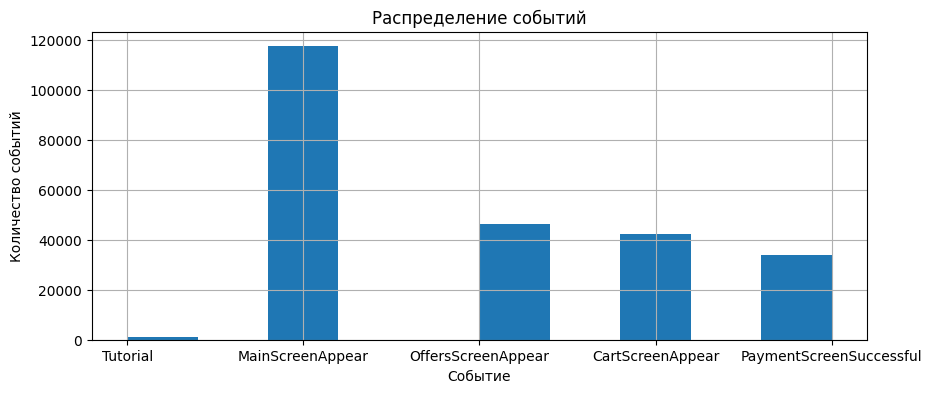

In [31]:
data['event_name'].hist(figsize=(10,4))
plt.xlabel('Событие')
plt.ylabel('Количество событий')
plt.title('Распределение событий')
plt.show()

Видим, что события `MainScreenAppear` и  `Tutorial` так и остались как наиболее часто и редко встречающиеся соответственно.

In [32]:
# считаем, сколько уникальных пользователей осталось
print('Уникальных пользователей в логе осталось', data['user_deviceid_hash'].nunique(), ', было - ', old_users_num,
      '\n','Потеряли -', 7551 - data['user_deviceid_hash'].nunique(), 
      '. Относительная потеря (в %) -',  round((1 - data['user_deviceid_hash'].nunique() / old_users_num) * 100, 3))



Уникальных пользователей в логе осталось 7534 , было -  7551 
 Потеряли - 17 . Относительная потеря (в %) - 0.225


In [33]:
# убедимся, что у нас остались пользователя всех 3х групп теста
data['expid'].value_counts()

248    84563
246    79302
247    77022
Name: expid, dtype: int64

В результате удаления части данных из датасета видим, что мы потеряли только 17 уникальных пользователей и 2826 событий, при этом все уникальные события сохранились.

## Изучение воронки событий

Еще раз посмотрим, какие события встречаются в логах и отсортируем их.

In [34]:
data['event_name'].value_counts()


MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Видим, что события расположились в следующем порядке: показ главного экрана, показ экрана предложений, показ экрана с корзиной, показ экрана об  успешной оплате, обучение.

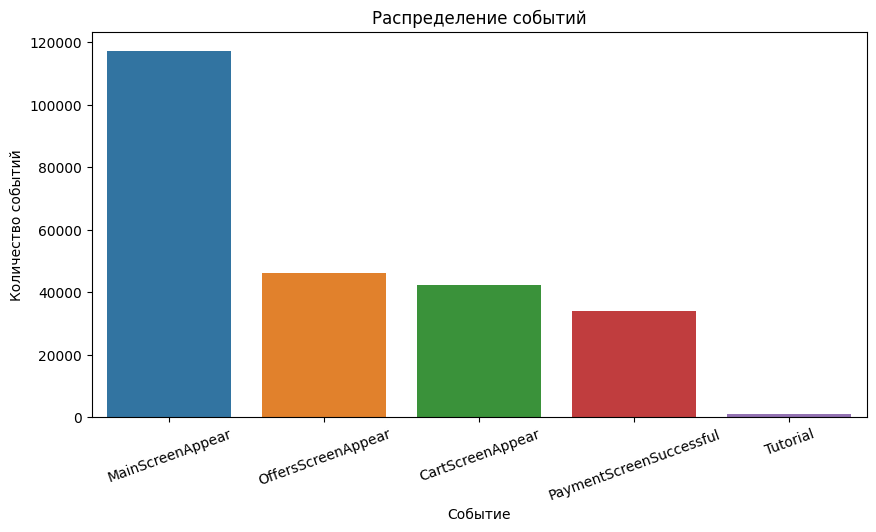

In [35]:
plt.figure(figsize=(10,5))
sns.barplot(x='index',y='event_name', data=data['event_name'].value_counts().reset_index())
plt.xlabel('Событие')
plt.ylabel('Количество событий')
plt.title('Распределение событий')
plt.xticks(rotation=20)
plt.show()

Также, посчитаем, сколько пользователей совершали каждое из указанных выше событий, и отсортируем события по числу пользователей. 

In [36]:
# считаем, сколько пользователей совершали каждое из событий
data_users_sorted = data.groupby('event_name').agg({'user_deviceid_hash':'nunique'})\
                          .sort_values(by=['user_deviceid_hash'], ascending=False).reset_index()
data_users_sorted

,event_name,user_deviceid_hash
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


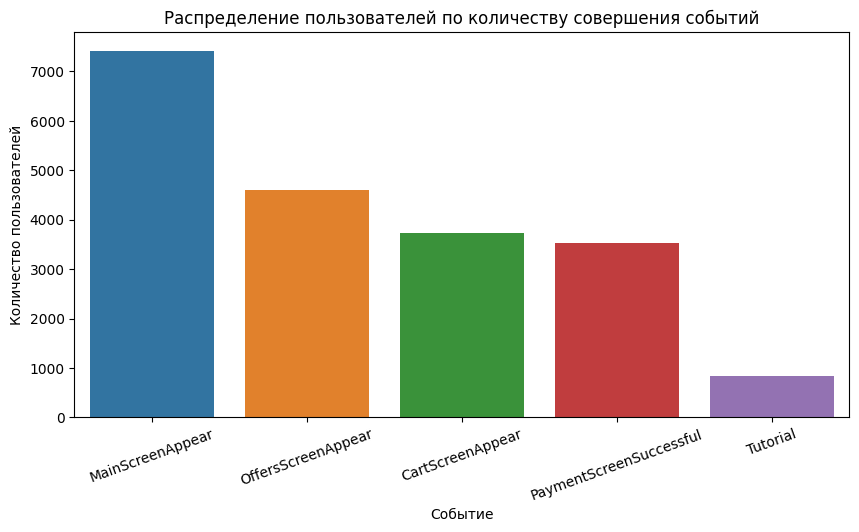

In [37]:
# визуализируем полученные данные
plt.figure(figsize=(10,5))
sns.barplot(x='event_name',y='user_deviceid_hash', data=data_users_sorted)
plt.xlabel('Событие')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по количеству совершения событий')
plt.xticks(rotation=20)
plt.show()

Посчитаем долю пользователей, которые хоть раз совершали событие.

In [38]:
data_users_sorted['%_users'] = round(data_users_sorted['user_deviceid_hash'] 
                                     / data['user_deviceid_hash'].nunique(),2) * 100
data_users_sorted

,event_name,user_deviceid_hash,%_users
0,MainScreenAppear,7419,98.0
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0




Видим, что по полученным данным складывается воронка событий, которая имеет следующий вид и последовательность:
1. показ главного экрана;
2. показ экрана предложений;
3. показ экрана с корзиной;
4. показ экрана об  успешной оплате.

Событие `Tutorial - обучение`, полагаем, следует отбросить, так как оно не является необходимой частью данной воронки.

In [39]:
data_users_sorted.drop(labels = [4], axis=0, inplace = True)
data_users_sorted

,event_name,user_deviceid_hash,%_users
0,MainScreenAppear,7419,98.0
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0


По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки, а также какая доля пользователей доходит от первого события до оплаты.

In [40]:
# дополняем датасет новым столбцом, который с помощью цикла считает соотношение следующего и последующего шагов
data_users_sorted['sales_funnel'] = 0
for i in range(len(data_users_sorted['user_deviceid_hash'])):
    if i == 0:
        data_users_sorted['sales_funnel'].iloc[i] = 1
    else: 
        data_users_sorted['sales_funnel'].iloc[i] = round(
        (data_users_sorted['user_deviceid_hash'].iloc[i] / data_users_sorted['user_deviceid_hash'].iloc[i-1]),2)
data_users_sorted

,event_name,user_deviceid_hash,%_users,sales_funnel
0,MainScreenAppear,7419,98.0,1.00
1,OffersScreenAppear,4593,61.0,0.62
2,CartScreenAppear,3734,50.0,0.81
3,PaymentScreenSuccessful,3539,47.0,0.95


Видим, следующую картину:
* на этап `показ экрана предложений` перешли только 61% от общего количества пользователей, падение конверсии составило почти 40%;
* на следующий этап `показ экрана с корзиной` перешло уже 81% пользователей - потеря 19% после предыдущего этапа;
* на следующий этап `показ экрана об успешной оплате` перешли 95% пользователей - потеря 5% пользователей.

Таким образом, больше всего пользователей были утеряны после этапа `показ главного экрана`, то есть 38% от общего количества пользователей не дошли до этапа `показ экрана предложений`.

In [41]:
# аналогичным образом считаем, какая доля пользователей доходит от первого события до оплаты, немного скорректировав предыдущий цикл
data_users_sorted['final_sales_funnel'] = 0
for i in range(len(data_users_sorted['user_deviceid_hash'])):
    if i == 0:
        data_users_sorted['final_sales_funnel'].iloc[i] = 1
    else: 
        data_users_sorted['final_sales_funnel'].iloc[i] = round(
        (data_users_sorted['user_deviceid_hash'].iloc[i] / data_users_sorted['user_deviceid_hash'].iloc[0]),2)
data_users_sorted

,event_name,user_deviceid_hash,%_users,sales_funnel,final_sales_funnel
0,MainScreenAppear,7419,98.0,1.00,1.00
1,OffersScreenAppear,4593,61.0,0.62,0.62
2,CartScreenAppear,3734,50.0,0.81,0.50
3,PaymentScreenSuccessful,3539,47.0,0.95,0.48


Видим, что до последнего этапа `показ экрана об успешной оплате` дошли 48% от общего числа имеющихся пользователей.

Также, для наглядности визуализируем нашу воронку событий. Построим два графика: на одном воронка будет в долях пользователей, перешедших на следующий этап, на другом - в количестве таких уникальных пользователей.

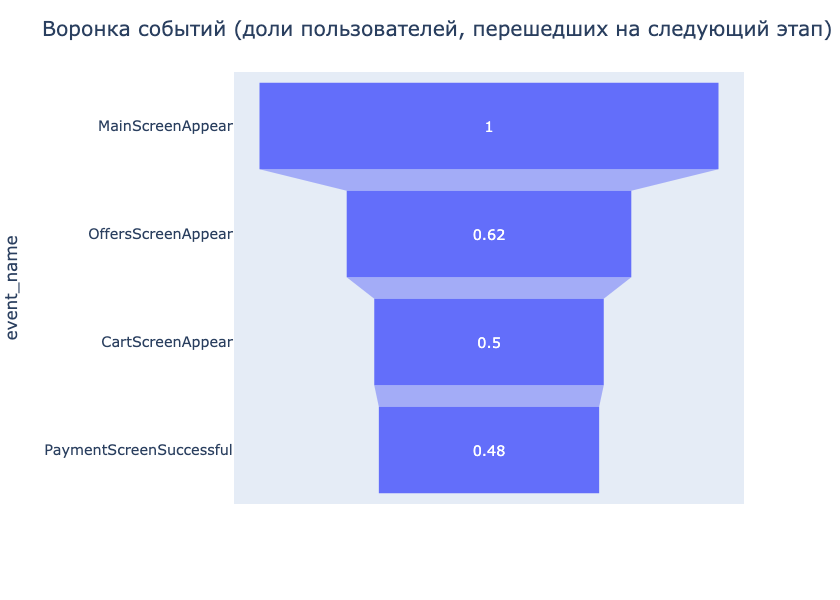

In [42]:
# строим воронку, показывающую долю пользователей, перешедших на следующий этап
fig = px.funnel(data_users_sorted, x='final_sales_funnel', y='event_name')
fig.update_layout(title="Воронка событий (доли пользователей, перешедших на следующий этап)")
fig.show()


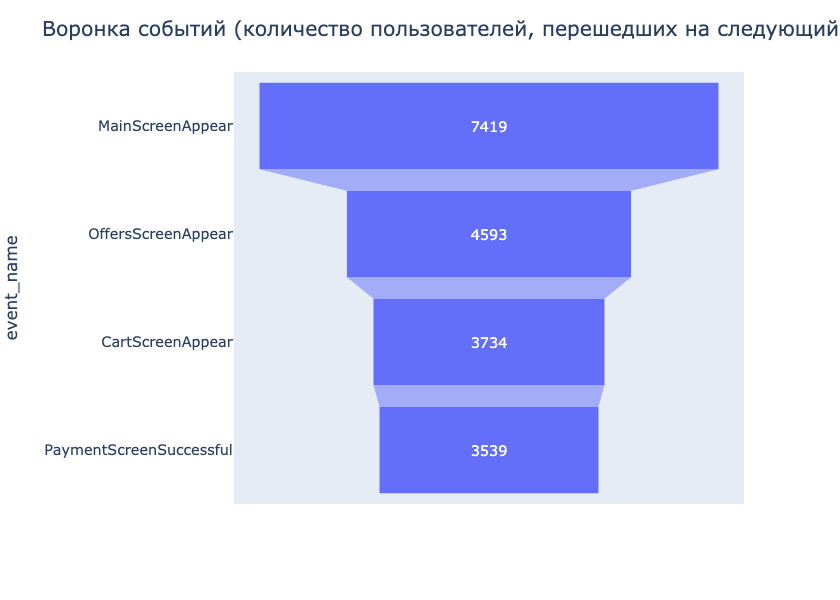

In [43]:
# строим воронку, показывающую количество пользователей, перешедших на следующий этап
fig = px.funnel(data_users_sorted, x='user_deviceid_hash', y='event_name')
fig.update_layout(title="Воронка событий (количество пользователей, перешедших на следующий этап)")
fig.show()

## Изучение результатов эксперимента

Посмотрим, сколько пользователей в каждой экспериментальной группе.

In [44]:
print('В группе 246 -', data.loc[data['expid'] == 246]['user_deviceid_hash'].nunique(), 'уникальных пользователей.')

В группе 246 - 2484 уникальных пользователей.


In [45]:
print('В группе 247 -', data.loc[data['expid'] == 247]['user_deviceid_hash'].nunique(), 'уникальных пользователей.')

В группе 247 - 2513 уникальных пользователей.


In [46]:
print('В группе 248 -', data.loc[data['expid'] == 248]['user_deviceid_hash'].nunique(), 'уникальных пользователей.')

В группе 248 - 2537 уникальных пользователей.


Видим, что самая маленькая группа - группа 246: 2484 уникальных пользователей, самая большая - группа 248: 2537 уникальных пользователей.

Проверим группы на пересечение пользователей.

In [47]:
unique_246 = data.loc[data['expid'] == 246, 'user_deviceid_hash'].unique()
unique_247 = data.loc[data['expid'] == 247, 'user_deviceid_hash'].unique()
np.isin(unique_246, unique_247).sum()

0

Видим, что пересечений пользователей в группах 246 и 247 нет. Однако, необходимо также проверить отсутствие пересечений между двумя А группами (246 и 247) и одной группой В (248) аналогичным способом. 

In [48]:
unique_aa = data.query('expid == 246 or expid == 247')['user_deviceid_hash'].unique()
unique_ab = data.loc[data['expid'] == 248, 'user_deviceid_hash'].unique()
np.isin(unique_aa, unique_ab).sum()

0

Также видим, что пересечения между двумя А группами и одной группой В отсутствуют.

Посмотрим, находят ли статистические критерии разницу между выборками 246 и 247, чтобы проверить корректность всех механизмов и расчётов. Для этого найдем самое популярное событие, посчитаем число пользователей, совершивших это событие в каждой из контрольных групп,  посчитаем долю пользователей, совершивших это событие.     
Затем проделаем то же самое для всех других событий, а также для группы 248 (группа В).    
Для начала, проверим, на сколько группа 247 больше группы 246, чтобы А/А тетс отработал корректно.

In [49]:
print('Группа 247 больше группы 246 на', round(1 - (data.loc[data['expid'] == 246]['user_deviceid_hash'].nunique() 
/ data.loc[data['expid'] == 247]['user_deviceid_hash'].nunique()),2) * 100, '%')

Группа 247 больше группы 246 на 1.0 %


Разница между размерами групп не превышает допустимый 1%.

Так как код для проведения всех статистетических тестов для всех групп и событий будет почти одинаковый, следует создать одну функцию, которую мы будем использовать несколько раз. При этом, одну функцию поместим в другую.     
Первая (вложенная фунцкция) будет лишь проводить статистический тест и выдавать его результат. Вторая (внешная) будет собирать данные для проведения теста и передать их в вложенную функцию.

Для проверки результатов А/В теста будем использовать z-тест, так как он проверяет равенство пропорций - то, с чем мы, как раз, и имеем дело в нашем случае.

Создадим сводную таблицу, из которой будем брать данные для проведения статистического теста.

In [50]:
data_test = data.pivot_table(index='expid', columns='event_name', values='user_deviceid_hash', aggfunc='nunique')
data_test

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
expid,,,,,
246,1266,2450,1542,1200,278
247,1238,2476,1520,1158,283
248,1230,2493,1531,1181,279


Видим, что для теста нам еще не хватает следующих данных:
1. Не хватает столбца с общим числом уникальных пользователей для каждой группы;
2. Не хватает строки с данными по объединенной А группе (группы 246 и 247) для проведения А/В теста.

Кроме того, у нас присутствует лишний столбцец `Tutorial`, его необходимо удалить.

In [51]:
#удаляем столбец Tutorial
del data_test['Tutorial']
# добавляем столбец с общим числом уникальных пользователей для каждой группы
data_test['Total_unique_users'] = [data.loc[data['expid'] == 246]['user_deviceid_hash'].nunique(),
                                  data.loc[data['expid'] == 247]['user_deviceid_hash'].nunique(),
                                  data.loc[data['expid'] == 248]['user_deviceid_hash'].nunique()]
#создаем стороку с данными для 249 группы (группа А)
data_test.loc['249'] = data_test.iloc[0] + data_test.iloc[1]
data_test

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total_unique_users
expid,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
249,2504,4926,3062,2358,4997


Теперь, все данные собраны. Можем приступать к написанию функций.

In [52]:
def z_test (success, trials, alpha):
    
    p1 = success[0] / trials[0]
    p2 = success[1] / trials[1]
    
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [53]:
def conduct_ztest (group_1, group_2, alpha):
    alpha_value = alpha
    total_users = ([data_test['Total_unique_users'].iloc[group_1], data_test['Total_unique_users'].iloc[group_2]])
    MainScreenAppear_users = ([data_test['MainScreenAppear'].iloc[group_1], data_test['MainScreenAppear'].iloc[group_2]])
    OffersScreenAppear_users = ([data_test['OffersScreenAppear'].iloc[group_1], data_test['OffersScreenAppear'].iloc[group_2]])
    CartScreenAppear_users = ([data_test['CartScreenAppear'].iloc[group_1], data_test['CartScreenAppear'].iloc[group_2]])
    PaymentScreenSuccessful_users = ([data_test['PaymentScreenSuccessful'].iloc[group_1], data_test['PaymentScreenSuccessful'].iloc[group_2]])
    
    print('Результаты теста по долям total_users и MainScreenAppear_users')
    z_test(MainScreenAppear_users, total_users, alpha_value)
    
    print('Результаты теста по долям total_users и OffersScreenAppear_users')
    z_test(OffersScreenAppear_users, total_users, alpha_value)
    
    print('Результаты теста по долям total_users и CartScreenAppear_users')
    z_test(CartScreenAppear_users, total_users, alpha_value)
    
    print('Результаты теста по долям total_users и PaymentScreenSuccessful_users')
    z_test(PaymentScreenSuccessful_users, total_users, alpha_value)
    

Для первого раунда тестов возьмем значение alpha равное 0.05. Затем проведем второй раунд теста с alpha равным 0.1, то есть с менее строгой проверкой, и посмотрим, как изменится результат.      
Сформулируем нулевую (Н0) и альтернативную (Н1) гипотезы.      
Н0: между долями групп отсутствует статистически значимые различия, нет оснований полагать, что доли разные.      
Н1: между долями групп есть статистически значимые различия, есть основания полагать, что доли разные.

In [54]:
# проверка на наличие статистически значимых различий между группами 246 и 247 (А/А тест)
conduct_ztest (0, 1, 0.05)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Видим, что по всем событиям не получилось отвергнуть нулевую гипотезу, соответственно нет оснований считать, что есть статистические значимые отличия между группами 246 и 247.    

Теперь повторим все то же самое для всех А групп (246, 247 и 249) с В группой (группа 248).

In [55]:
# проверка на наличие статистически значимых различий между группами 246 и 248 (А1/В тест)
conduct_ztest (0, 2, 0.05)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [56]:
# проверка на наличие статистически значимых различий между группами 247 и 248 (А2/В тест)
conduct_ztest (1, 2, 0.05)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [57]:
# проверка на наличие статистически значимых различий между объединенными группами 246 и 247 и группой 248 (А/В тест)
conduct_ztest (3, 2, 0.05)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Видим, что по результатам z-теста нет оснований для того, чтобы отвергнуть нулевую гипотезу о том, что доли равны. Соответственно, при заданном уровне статистической значимости, полагаю, изменение шрифта не оказало какого-либо значимого влияния на поведение пользователей.     

Попробуем провести второй раунд теста с более высокоим уровнем alpha - 0.1.

In [58]:
# проверка на наличие статистически значимых различий между группами 246 и 248 (А1/В тест)
conduct_ztest (0, 2, 0.1)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [59]:
# проверка на наличие статистически значимых различий между группами 247 и 248 (А2/В тест)
conduct_ztest (1, 2, 0.1)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [60]:
# проверка на наличие статистически значимых различий между группами 247 и 248 (А/В тест)
conduct_ztest (3, 2, 0.1)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Снова видим, что также нет оснований отклонить нулевую гипотезу, за исключением только одного случая. Соответственно, даже для менее строго уровня alpha z-тест не видит статистических значимых отличий между группами.     
Таким образом, есть основания полагать, что новая фича в виде измененного шрифта не оправдала себя.

При проведении А/В теста и анализе его результатов было выполнено 4 z-теста с уровнем статистичемской значимости alpha - 0.05, из которых 1 А/А тест, и 3 z-теста с уровнем статистичемской значимости alpha - 0.1, то есть без учета А/А теста мы проводим 3 А/В теста.     
Однако, учитыая, что при тестировании гипотезы мы проводили множественные сравнения, для более корректного проведения статистического теста необходимо скорректировать уровень статистической значимости для снижения вероятности ложнопозитивного результата. Воспользуемся методом Шидака.

In [61]:
# подставляем наши значения в формулу
shidak_alpha = round(1 - (1 - 0.05)**(1/3),3)
print('Новое значение alpha с учетом поправки Шидака равно -',shidak_alpha,'.')

Новое значение alpha с учетом поправки Шидака равно - 0.017 .


Проведем еще z-тест еще раз, но с скорректированным значением alpha.

In [62]:
conduct_ztest (0, 2, shidak_alpha)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [63]:
conduct_ztest (1, 2, shidak_alpha)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [64]:
conduct_ztest (3, 2, shidak_alpha)

Результаты теста по долям total_users и MainScreenAppear_users
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и OffersScreenAppear_users
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и CartScreenAppear_users
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям total_users и PaymentScreenSuccessful_users
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Видим, что с скорректированным значением alpha тест также не находит каких-либо статистически значимых различий между группами: изменение шрифта не привело к каким-либо изменениям в поведении пользователей.

## Общие выводы

В процессе выполнения и анализа А/А/В теста были выполнены следующие действия:
* удалены старые данные в логе;
* построена воронка событий;
* проведен z- test.

**Основной вывод** - изменение шрифта не привело к каким-либо статически значимым изменениям в поведении пользователей. Введение фичи не оправдало себя.

Также , к важным наблюдениям можно отнести следующие:
* всего былоо 7419 уникальных пользователей;
* до последнего этапа `показ экрана об успешной оплате` дошли 48% от общего числа имеющихся пользователей, а именно - 3539;
* больше всего пользователей были утеряны после этапа `показ главного экрана`: 2893 или 39% от общего количества пользователей не дошли до следующего этапа `показ экрана предложений`.
